# RAG Evaluation

Evaluate our results from different experiments. We saved our experiment results in csv files. We will load these files and evaluate our generated answers with the ground truths with the evaluation framework `ragas`.

## Imports

In [3]:
import os
from dotenv import load_dotenv
import pandas as pd
import ast
from ragas import EvaluationDataset, evaluate
from ragas.metrics import (
    context_precision,
    context_recall,
    faithfulness,
    answer_relevancy,
)
from tqdm import tqdm
import time

from openai import AzureOpenAI
import openai

import credentials

In [4]:
deployment_name = "gpt-4"

client = AzureOpenAI(
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),  
    api_version="2023-12-01-preview",
    azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
)

In [5]:
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

# check if openai key is set
openai.api_key = os.getenv("OPENAI_API_KEY")
if openai.api_key is None:
    raise ValueError("OpenAI API key is not set")

try:
    response = client.chat.completions.create(
        messages=[{"role": "user", "content": "Hello, GPT-4!"}],
        model=deployment_name,
        max_tokens=10
    )
    print(response)
except Exception as e:
    print("Error:", e)

ChatCompletion(id='chatcmpl-AVfrVEf1LKYGQBBfhd1dTdyhbcO4z', choices=[Choice(finish_reason='length', index=0, logprobs=None, message=ChatCompletionMessage(content="Hello! I'm actually an AI model developed by", refusal=None, role='assistant', audio=None, function_call=None, tool_calls=None), content_filter_results={'hate': {'filtered': False, 'severity': 'safe'}, 'protected_material_code': {'filtered': False, 'detected': False}, 'protected_material_text': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}})], created=1732112449, model='gpt-4', object='chat.completion', service_tier=None, system_fingerprint=None, usage=CompletionUsage(completion_tokens=10, prompt_tokens=14, total_tokens=24, completion_tokens_details=None, prompt_tokens_details=None), prompt_filter_results=[{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': Fals

## Load CSV files

In [6]:
def process_retrieved_contexts(row):
    if isinstance(row, str):  # If it's a string representation of a list
        parsed = ast.literal_eval(row)  # Parse the string into a list
        return parsed if isinstance(parsed, list) else [parsed]
    elif isinstance(row, list):  # If it's already a list
        return row
    else:  # If it's something else, convert to a single-item list
        return [row]

In [7]:
folder_path = "../data/experiments"
experiment_dataframes = {}

# Iterate over all files in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        # Read the CSV file
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_csv(file_path)

        # Select columns
        df = df[['question', 'answer', 'contexts', 'ground_truth']]

        # Rename columns
        df = df.rename(columns={
            'question': 'user_input',
            'contexts': 'retrieved_contexts',
            'answer': 'response', 
            'ground_truth': 'reference'
        })

        # Ensure every row in `retrieved_contexts` is a list
        df['retrieved_contexts'] = df['retrieved_contexts'].apply(process_retrieved_contexts)

        experiment_dataframes[file_name] = df

# Check loaded datasets
print(f"Loaded datasets for {len(experiment_dataframes)} experiments.")

for experiment_name, dataset in experiment_dataframes.items():
    print(f"Experiment: {experiment_name}, Number of samples: {len(dataset)}")

Loaded datasets for 3 experiments.
Experiment: recursive_1000_chunksize_100_overlap_text_embedding_3_large.csv, Number of samples: 23
Experiment: recursive_500_chunksize_50_overlap_text_embedding_ada_002.csv, Number of samples: 23
Experiment: recursive_1000_chunksize_0_overlap_text_embedding_ada_002.csv, Number of samples: 23


## Retrieval Evaluation

Precision@K:
- Precision@K evaluates the proportion of relevant items among the top K retrieved items.
- It is explicitly limited to the top K items, meaning the implementation would need to only consider the first K retrieved contexts.

Recall@K:
- Recall@K evaluates the proportion of relevant items retrieved among the total number of relevant items, limited to the top K items retrieved.
- It focuses on how well the top K retrieved contexts cover all relevant contexts.

In [8]:
def custom_context_precision(retrieved_contexts, ground_truth):
    """Calculate Context Precision: Proportion of relevant retrieved contexts."""
    if not retrieved_contexts:
        return 0.0
    relevant = sum(1 for context in retrieved_contexts if ground_truth in context)
    return relevant / len(retrieved_contexts)

def custom_context_recall(retrieved_contexts, ground_truth):
    """Calculate Context Recall: Proportion of the ground truth found in retrieved contexts."""
    if not retrieved_contexts:
        return 0.0
    relevant = sum(1 for context in retrieved_contexts if ground_truth in context)
    return 1.0 if relevant > 0 else 0.0

def precision_at_k(retrieved_contexts, ground_truth, k):
    """Calculate Precision@K."""
    retrieved_top_k = retrieved_contexts[:k]  # Only consider top K contexts
    relevant = sum(1 for context in retrieved_top_k if ground_truth in context)
    return relevant / len(retrieved_top_k) if retrieved_top_k else 0.0

def recall_at_k(retrieved_contexts, ground_truth, k):
    """Calculate Recall@K."""
    retrieved_top_k = retrieved_contexts[:k]
    relevant = sum(1 for context in retrieved_top_k if ground_truth in context)
    return relevant / 1.0  # Assuming there's only one ground truth match

In [11]:
evaluation_results = {}

for experiment_name, dataset in experiment_dataframes.items():
    experiment_name = experiment_name[:-4]
    print(f"Evaluating experiment: {experiment_name}")
    
    precisions, recalls, precision_at_ks, recalls_at_k = [], [], [], []
    for _, row in dataset.iterrows():
        precisions.append(custom_context_precision(row['retrieved_contexts'], row['reference']))
        recalls.append(custom_context_recall(row['retrieved_contexts'], row['reference']))
        precision_at_ks.append(precision_at_k(row['retrieved_contexts'], row['reference'], 5))
        recalls_at_k.append(recall_at_k(row['retrieved_contexts'], row['reference'], 5))
    
    # Add metrics to DataFrame
    dataset['context_precision'] = precisions
    dataset['context_recall'] = recalls
    dataset['precision_at_5'] = precision_at_ks
    dataset['recall_at_5'] = recalls_at_k

    # Store results
    evaluation_results[experiment_name] = dataset

    # Summary
    print(f"Completed evaluation for {experiment_name}")
    print(f"Average Context Precision: {dataset['context_precision'].mean():.2f}")
    print(f"Average Context Recall: {dataset['context_recall'].mean():.2f}")
    print(f"Average Precision@5: {dataset['precision_at_5'].mean():.2f}")
    print(f"Average Recall@5: {dataset['recall_at_5'].mean():.2f}")
    print("--"*45)

Evaluating experiment: recursive_1000_chunksize_100_overlap_text_embedding_3_large
Completed evaluation for recursive_1000_chunksize_100_overlap_text_embedding_3_large
Average Context Precision: 0.06
Average Context Recall: 0.13
Average Precision@5: 0.06
Average Recall@5: 0.30
------------------------------------------------------------------------------------------
Evaluating experiment: recursive_500_chunksize_50_overlap_text_embedding_ada_002
Completed evaluation for recursive_500_chunksize_50_overlap_text_embedding_ada_002
Average Context Precision: 0.07
Average Context Recall: 0.13
Average Precision@5: 0.07
Average Recall@5: 0.35
------------------------------------------------------------------------------------------
Evaluating experiment: recursive_1000_chunksize_0_overlap_text_embedding_ada_002
Completed evaluation for recursive_1000_chunksize_0_overlap_text_embedding_ada_002
Average Context Precision: 0.03
Average Context Recall: 0.09
Average Precision@5: 0.03
Average Recall@

## Evaluation with RAGAs

In [ ]:
from ragas.dataset_schema import EvaluationDataset, SingleTurnSample
from ragas import RunConfig

my_run_config = RunConfig(timeout=3600)

# Define metrics to evaluate
metrics = [context_precision, context_recall, faithfulness, answer_relevancy]

evaluation_results = {}

for experiment_name, eval_dataset in experiment_dataframes.items():
    print(f"Processing experiment: {experiment_name}")
    
    samples = []
    for _, row in eval_dataset.iterrows():
        sample = SingleTurnSample(
            user_input=row['user_input'],
            retrieved_contexts=row['retrieved_contexts'],
            response=row['response'],
            reference=row['reference']
        )
        samples.append(sample)
    
    evaluation_dataset = EvaluationDataset(samples=samples)

    results = evaluate(
        dataset=evaluation_dataset,
        metrics=metrics,
        run_config=my_run_config,
    )
    evaluation_results[experiment_name] = results
    print(f"Completed evaluation for {experiment_name}")

In [ ]:
from ragas.dataset_schema import EvaluationDataset, SingleTurnSample
from ragas.metrics import context_precision, context_recall, faithfulness, answer_relevancy
from ragas.evaluation import evaluate
from ragas.llms import LangchainLLMWrapper
from langchain.chat_models import ChatOpenAI

# Specify the GPT-4 LLM
evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model=deployment_name, temperature=0))

# Define metrics to evaluate
metrics = [context_precision, context_recall, faithfulness, answer_relevancy]

evaluation_results = {}

# Iterate through each experiment dataset
for experiment_name, eval_dataset in experiment_dataframes.items():
    print(f"Processing experiment: {experiment_name}")
    
    samples = []
    # Prepare the dataset samples
    for _, row in eval_dataset.iterrows():
        sample = SingleTurnSample(
            user_input=row['user_input'],
            reference=row['reference'],
            response=row['response'],
            retrieved_contexts=row['retrieved_contexts']
        )
        samples.append(sample)
    
    # Create the EvaluationDataset
    evaluation_dataset = EvaluationDataset(samples=samples)

    # Run evaluation with GPT-4 as the LLM
    results = evaluate(
        dataset=evaluation_dataset,
        metrics=metrics,
        llm=evaluator_llm
    )
    
    # Store results for the experiment
    evaluation_results[experiment_name] = results
    print(f"Completed evaluation for {experiment_name}")
    print(results.to_pandas().head())

## Evaluation with LLM

- reference = ground truth
- response = generated answer

Deep Eval could also be tried for evaluation.

In [12]:
def evaluate_with_llm(client, deployment_name, user_input, reference, response, retrieved_contexts):
    """
    Evaluate the generated response using the specified LLM.
    """
    prompt = f"""
        You are an evaluator for a Retrieval-Augmented Generation (RAG) system. Assess the quality of the following output:

        Question: {user_input}

        Reference Answer: {reference}

        Generated Answer: {response}

        Retrieved Contexts:
        {retrieved_contexts}

        Evaluation Criteria:
        1. **Relevance**: Does the generated answer address the question correctly and refer to the retrieved contexts? Rate on a scale of 1-10.
        2. **Accuracy**: Does the generated answer align with the reference answer? Rate on a scale of 1-10.
        3. **Faithfulness**: Is the generated answer faithful to the retrieved contexts? Rate on a scale of 1-10.
        4. **Overall Comments**: Provide any additional comments about the answer quality.

        Provide your evaluation in the following JSON format:
        {{
            "Relevance": X,
            "Accuracy": X,
            "Faithfulness": X,
            "OverallComments": "Your comments here."
        }}
    """
    # Query the Azure OpenAI endpoint
    try:
        response = client.chat.completions.create(
            model=deployment_name,
            messages=[{"role": "user", "content": prompt}],
            max_tokens=250,
            temperature=0.0
        )
        answer = response.choices[0].message.content.strip()
        return answer

    except Exception as e:
        return {"error": str(e)}

# Iterate through the dataset
def evaluate_dataset(client, deployment_name, eval_dataset):
    results = []
    for _, row in tqdm(eval_dataset.iterrows(), total=len(eval_dataset), desc="Evaluating with LLM"):
        user_input = row['user_input']
        reference = row['reference']
        response = row['response']
        retrieved_contexts = row['retrieved_contexts']
        
        evaluation = evaluate_with_llm(
            client, deployment_name, user_input, reference, response, retrieved_contexts
        )
        results.append({
            "user_input": user_input,
            "reference": reference,
            "response": response,
            "retrieved_contexts": retrieved_contexts,
            "evaluation": evaluation
        })
    return results

# Evaluate all experiment datasets
all_results = {}
for experiment_name, eval_dataset in experiment_dataframes.items():
    print(f"Evaluating experiment: {experiment_name}")
    results = evaluate_dataset(client, deployment_name, eval_dataset)
    all_results[experiment_name] = results
    print(f"Completed evaluation for {experiment_name}")

Evaluating experiment: recursive_1000_chunksize_100_overlap_text_embedding_3_large.csv


Evaluating with LLM: 100%|██████████| 23/23 [01:56<00:00,  5.05s/it]


Completed evaluation for recursive_1000_chunksize_100_overlap_text_embedding_3_large.csv
Evaluating experiment: recursive_500_chunksize_50_overlap_text_embedding_ada_002.csv


Evaluating with LLM: 100%|██████████| 23/23 [01:44<00:00,  4.53s/it]


Completed evaluation for recursive_500_chunksize_50_overlap_text_embedding_ada_002.csv
Evaluating experiment: recursive_1000_chunksize_0_overlap_text_embedding_ada_002.csv


Evaluating with LLM: 100%|██████████| 23/23 [01:52<00:00,  4.91s/it]

Completed evaluation for recursive_1000_chunksize_0_overlap_text_embedding_ada_002.csv


### Parse and Prepare the Evaluation Data

In [73]:
import json

data_for_plotting = []

# Iterate through all experiments and their evaluation results
for experiment_name, results in all_results.items():
    for result in results:
        try:
            # Parse the evaluation JSON
            evaluation = json.loads(result["evaluation"])
            
            # Add relevant data to the plotting list
            data_for_plotting.append({
                "Experiment": experiment_name,
                "Question": result["user_input"],
                "Reference": result["reference"],
                "GeneratedAnswer": result["response"],
                "RetrievedContexts": result["retrieved_contexts"],
                "Relevance": evaluation.get("Relevance", 0),
                "Accuracy": evaluation.get("Accuracy", 0),
                "Faithfulness": evaluation.get("Faithfulness", 0),
                "OverallComments": evaluation.get("OverallComments", "")
            })
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON for question: {result['user_input']}")
            continue

evaluation_df = pd.DataFrame(data_for_plotting)

# Reorder the columns for clarity
evaluation_df = evaluation_df[
    [
        "Experiment", "Question","Reference", "GeneratedAnswer", "RetrievedContexts", 
        "Relevance", "Accuracy", "Faithfulness", "OverallComments"
     ]
]
evaluation_df.head()

,Experiment,Question,Reference,GeneratedAnswer,RetrievedContexts,Relevance,Accuracy,Faithfulness,OverallComments
0,recursive_1000_chunksize_100_overlap_text_embe...,What is the innovation behind Leclanché's new ...,Leclanché's innovation is using a water-based ...,Leclanché has developed an environmentally fri...,[the use of organic solvents also eliminates t...,10,10,10,The generated answer is highly relevant to the...
1,recursive_1000_chunksize_100_overlap_text_embe...,What is the EU’s Green Deal Industrial Plan?,The EU’s Green Deal Industrial Plan aims to en...,The EU's Green Deal Industrial Plan is a strat...,['The EU has presented its Green Deal Industri...,9,8,10,The generated answer is highly relevant to the...
2,recursive_1000_chunksize_100_overlap_text_embe...,What is the EU’s Green Deal Industrial Plan?,The EU’s Green Deal Industrial Plan aims to en...,The EU's Green Deal Industrial Plan is an init...,['The EU has presented its Green Deal Industri...,10,9,10,The generated answer is highly relevant to the...
3,recursive_1000_chunksize_100_overlap_text_embe...,What are the four focus areas of the EU's Gree...,The four focus areas of the EU's Green Deal In...,"The four focus areas, or pillars, of the EU's ...",[to present the main outlines of the EU's Gree...,10,10,10,The generated answer is highly relevant to the...
4,recursive_1000_chunksize_100_overlap_text_embe...,When did the cooperation between GM and Honda ...,July 2013,The cooperation between GM and Honda on fuel c...,[was also hammering away at the challenge of i...,10,10,10,The generated answer is highly relevant to the...


### Visualize the Results

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the color palette
colors = ["skyblue", "salmon", "lightgreen"]

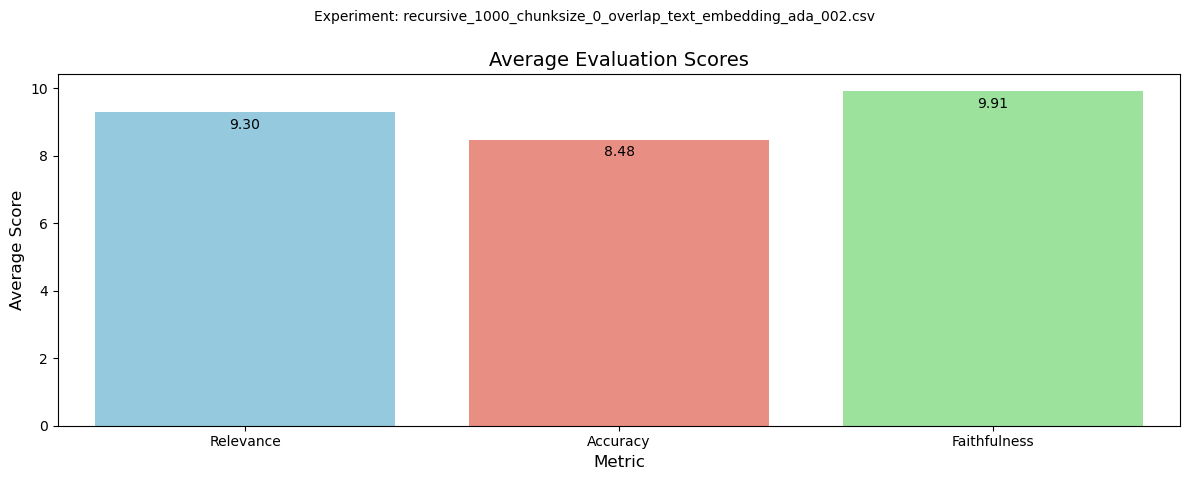

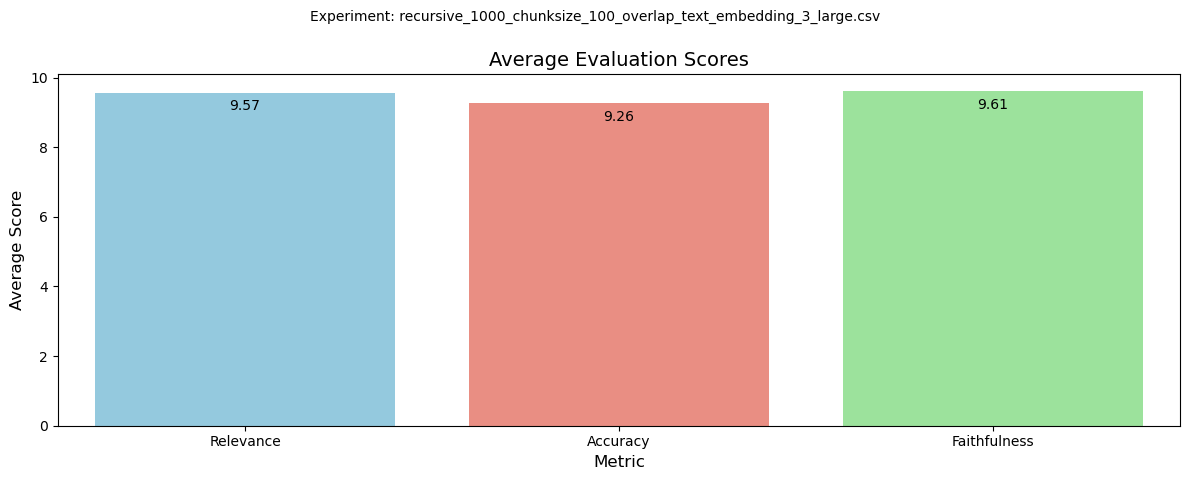

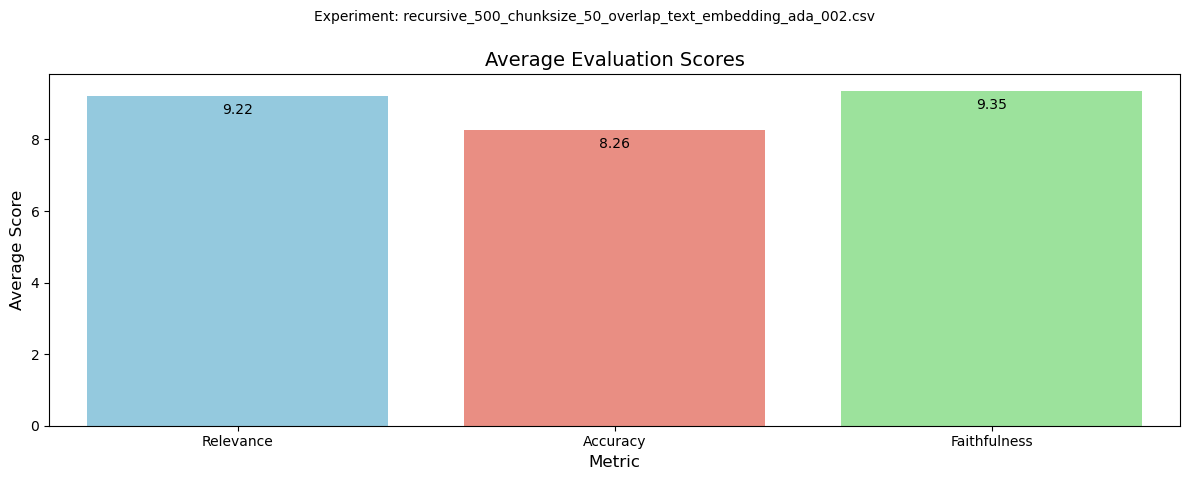

In [75]:
# Iterate through each experiment and its grouped data
for experiment_name, group_data in evaluation_df.groupby("Experiment"):
    # Aggregate the mean scores for this experiment
    mean_scores = group_data[["Relevance", "Accuracy", "Faithfulness"]].mean().reset_index()
    mean_scores.columns = ["Metric", "Score"]
    
    plt.figure(figsize=(12, 5))
    sns.barplot(x="Metric", y="Score", data=mean_scores, palette=colors)

    # Annotate the bars with mean values
    for i, row in mean_scores.iterrows():
        plt.text(i, row["Score"] - 0.5, f"{row['Score']:.2f}", ha="center", fontsize=10, color="black")

    plt.title("\nAverage Evaluation Scores", fontsize=14)
    plt.suptitle(f"Experiment: {experiment_name}", fontsize=10, y=0.95)
    plt.xlabel("Metric", fontsize=12)
    plt.ylabel("Average Score", fontsize=12)
    plt.tight_layout()
    plt.show()

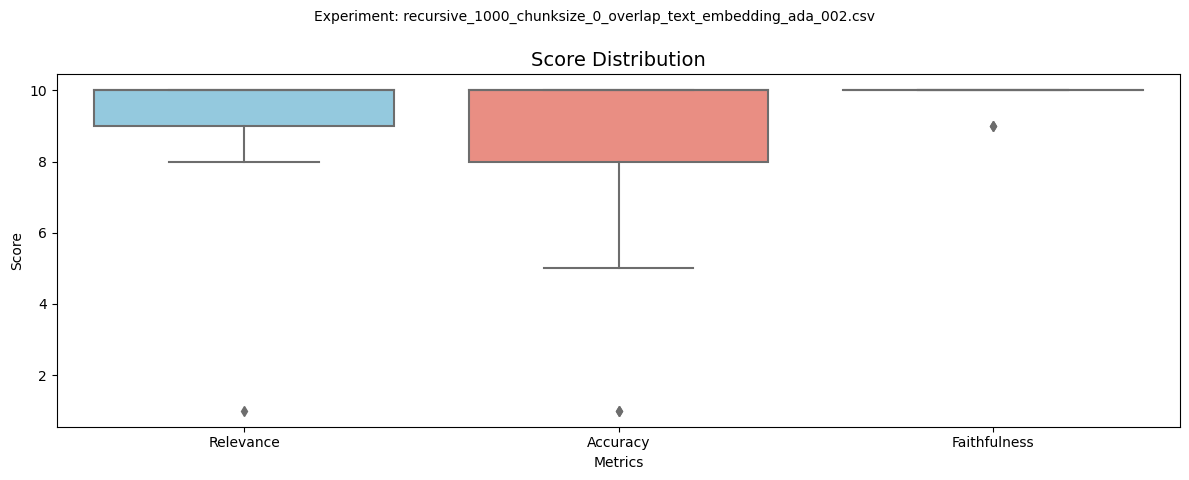

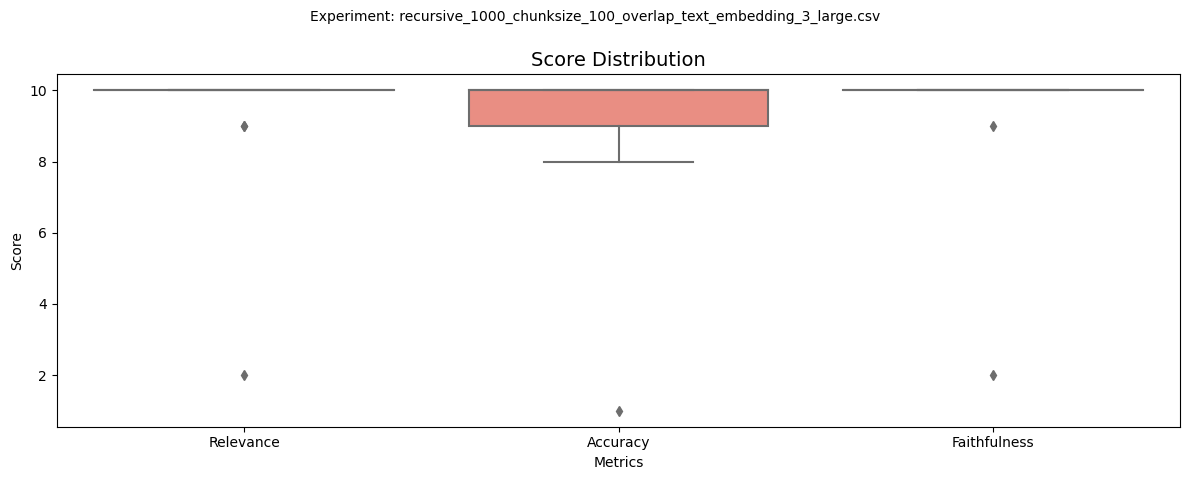

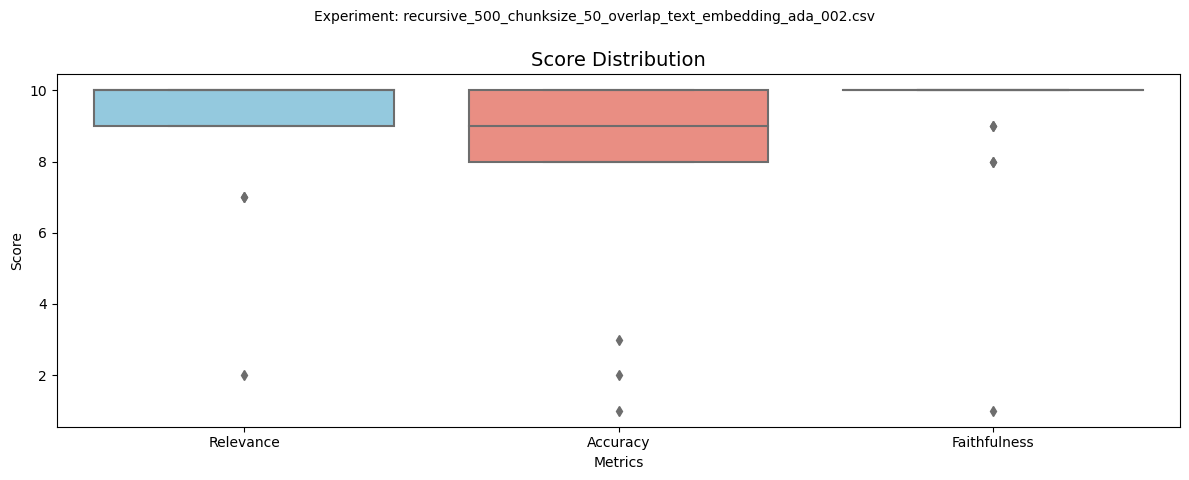

In [76]:
for experiment_name, group_data in evaluation_df.groupby("Experiment"):
    # Melt the data to long format for seaborn
    melted_data = group_data.melt(
        id_vars=["Experiment"],
        value_vars=["Relevance", "Accuracy", "Faithfulness"],
        var_name="Metric",
        value_name="Score"
    )

    plt.figure(figsize=(12, 5))
    sns.boxplot(
        data=melted_data,
        x="Metric",
        y="Score",
        palette=colors,
        linewidth=1.5
    )

    plt.title("\nScore Distribution", fontsize=14)
    plt.suptitle(f"Experiment: {experiment_name}", fontsize=10, y=0.95)
    plt.xlabel("Metrics")
    plt.ylabel("Score")
    plt.tight_layout()
    plt.show()

In [83]:
# show 3 lowest scoring responses
lowest_relevance = evaluation_df.nsmallest(3, "Relevance")

# show Question and Generated Answer
for i in range(3):
    print(f"Experiment: {lowest_relevance.iloc[i]['Experiment']}")
    print(f"Question: {lowest_relevance.iloc[i]['Question']}")
    print(f"Reference Answer: {lowest_relevance.iloc[i]['Reference']}")
    print(f"Generated Answer: {lowest_relevance.iloc[i]['GeneratedAnswer']}")
    print("\n")

Experiment: recursive_1000_chunksize_0_overlap_text_embedding_ada_002.csv
Question: In 2021, what were the top 3 states in the US in terms of total solar power generating capacity?
Reference Answer: California, Texas, and Florida
Generated Answer: The context does not provide specific information on the top 3 states in terms of total solar power generating capacity in the United States for the year 2021.


Experiment: recursive_1000_chunksize_100_overlap_text_embedding_3_large.csv
Question: In 2021, what were the top 3 states in the US in terms of total solar power generating capacity?
Reference Answer: California, Texas, and Florida
Generated Answer: The context does not provide specific information on the top 3 states in the US in terms of total solar power generating capacity for the year 2021.


Experiment: recursive_500_chunksize_50_overlap_text_embedding_ada_002.csv
Question: In 2021, what were the top 3 states in the US in terms of total solar power generating capacity?
Referenc

In [81]:
lowest_accuracy = evaluation_df.nsmallest(3, "Accuracy")

# show Question and Generated Answer
for i in range(3):
    print(f"Experiment: {lowest_accuracy.iloc[i]['Experiment']}")
    print(f"Question: {lowest_accuracy.iloc[i]['Question']}")
    print(f"Reference Answer: {lowest_accuracy.iloc[i]['Reference']}")
    print(f"Generated Answer: {lowest_accuracy.iloc[i]['GeneratedAnswer']}")
    print("\n")

Experiment: recursive_1000_chunksize_100_overlap_text_embedding_3_large.csv
Question: In 2021, what were the top 3 states in the US in terms of total solar power generating capacity?
Reference Answer: California, Texas, and Florida
Generated Answer: The context does not provide specific information on the top 3 states in the US in terms of total solar power generating capacity for the year 2021.


Experiment: recursive_500_chunksize_50_overlap_text_embedding_ada_002.csv
Question: In 2021, what were the top 3 states in the US in terms of total solar power generating capacity?
Reference Answer: California, Texas, and Florida
Generated Answer: The context does not provide specific information on the top 3 states in terms of total solar power generating capacity in the US for the year 2021.


Experiment: recursive_1000_chunksize_0_overlap_text_embedding_ada_002.csv
Question: Where do the turbines used in Icelandic geothermal power plants come from?
Reference Answer: Japan
Generated Answer:

In [82]:
lowest_faithfulness = evaluation_df.nsmallest(3, "Faithfulness")

# show Question and Generated Answer
for i in range(3):
    print(f"Experiment: {lowest_faithfulness.iloc[i]['Experiment']}")
    print(f"Question: {lowest_faithfulness.iloc[i]['Question']}")
    print(f"Reference Answer: {lowest_faithfulness.iloc[i]['Reference']}")
    print(f"Generated Answer: {lowest_faithfulness.iloc[i]['GeneratedAnswer']}")
    print("\n")

Experiment: recursive_500_chunksize_50_overlap_text_embedding_ada_002.csv
Question: In 2021, what were the top 3 states in the US in terms of total solar power generating capacity?
Reference Answer: California, Texas, and Florida
Generated Answer: The context does not provide specific information on the top 3 states in terms of total solar power generating capacity in the US for the year 2021.


Experiment: recursive_1000_chunksize_100_overlap_text_embedding_3_large.csv
Question: In 2021, what were the top 3 states in the US in terms of total solar power generating capacity?
Reference Answer: California, Texas, and Florida
Generated Answer: The context does not provide specific information on the top 3 states in the US in terms of total solar power generating capacity for the year 2021.


Experiment: recursive_500_chunksize_50_overlap_text_embedding_ada_002.csv
Question: What are the four focus areas of the EU's Green Deal Industrial Plan?
Reference Answer: The four focus areas of the 